# Data description & Problem statement: 

Hyundai Heavy Industries is one of the world's largest ship manufacturing companies and builds cruise liners. Suppose you've been flown to their headquarters in Ulsan, South Korea to help them give accurate estimates of how many crew members a ship will require. They are currently building new ships for some customers and want you to create a model and use it to predict how many crew members the ships will need.

The data has 158 rows and 9 variables. This is a regression problem. The goal is to creat a regression model that will help predict how many crew members will be needed for future ships.


 # Workflow:
- Load the dataset, and define the required functions (e.g. for detecting the missing values, etc.)
- Data Cleaning/Wrangling: Manipulate outliers, missing data or duplicated values, etc. 
- Basic data exploration
- Preparing data for Machine Learning:
    - One-hot-encoding of categorical features
    - Vector Assembling
    - Splitting data into training & test parts (I use the training part for training & hyperparameter tuning of models, test part for the final evaluation of models)
    
 # Model Training: 
- I separately train following models:
     - Linear Regression (LR)
     - Random Forest (RF)
     - Gradient Boosting Trees (GBTs)
     
 Note: I use Grid-Search technique to find optimal hyper-parameters of each model.
 

  # Model Evaluation: 
- I separately evaluate the best LR, RF and GBT models, by calculating/plotting following mertics on Test dataset:
     - R^2 score
     - RMSE
 
 
- Calculating the Feature Importance with RF and GBTs models.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import findspark 
findspark.init('/home/rhashemee/spark-2.1.0-bin-hadoop2.7')

import pyspark

import sklearn
import numpy as np
import pandas as pd
import imblearn as im
import featuretools as ft
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# helpful function to detect the Missing Values:
def detect_missing(df):
    import pyspark.sql.functions as fn
    miss_count=df.agg(*[(fn.count('*')-fn.count(c)).alias(c)   for c in df.columns]).toPandas()
    miss_percent=df.agg(*[(1-(fn.count(c)/fn.count('*'))).alias(c)   for c in df.columns]).toPandas()
    
    summary = pd.concat([miss_count, miss_percent], axis=0)
    summary['  '] = ['Count of miss values: ', 'Percentage of miss values: ']
    summary.set_index('  ', inplace=True)
    return summary

# helpful function to detect the Duplicate Values:
def detect_duplicates(df):
    print('Count of rows: ', df.count())
    print('Count of distinct rows: ', df.distinct().count())

In [3]:
from pyspark.sql import SparkSession
my_spark=SparkSession.builder.appName('Hyundai_project').getOrCreate()

In [4]:
df=my_spark.read.csv('cruise_ship_info.csv', header=True, inferSchema=True)

In [5]:
df.printSchema()

root
 |-- Ship_name: string (nullable = true)
 |-- Cruise_line: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tonnage: double (nullable = true)
 |-- passengers: double (nullable = true)
 |-- length: double (nullable = true)
 |-- cabins: double (nullable = true)
 |-- passenger_density: double (nullable = true)
 |-- crew: double (nullable = true)



In [6]:
pd.DataFrame(df.take(3), columns=df.columns)

,Ship_name,Cruise_line,Age,Tonnage,passengers,length,cabins,passenger_density,crew
0,Journey,Azamara,6,30.277,6.94,5.94,3.55,42.64,3.55
1,Quest,Azamara,6,30.277,6.94,5.94,3.55,42.64,3.55
2,Celebration,Carnival,26,47.262,14.86,7.22,7.43,31.80,6.70


In [7]:
df.describe().toPandas()

,summary,Ship_name,Cruise_line,Age,Tonnage,passengers,length,cabins,passenger_density,crew
0,count,158,158,158,158,158,158,158,158,158
1,mean,Infinity,None,15.689873417721518,71.28467088607599,18.45740506329114,8.130632911392404,8.830000000000005,39.90094936708861,7.794177215189873
2,stddev,NaN,None,7.615691058751413,37.229540025907866,9.677094775143416,1.793473548054825,4.4714172221480615,8.63921711391542,3.503486564627034
3,min,Adventure,Azamara,4,2.329,0.66,2.79,0.33,17.7,0.59
4,max,Zuiderdam,Windstar,48,220.0,54.0,11.82,27.0,71.43,21.0


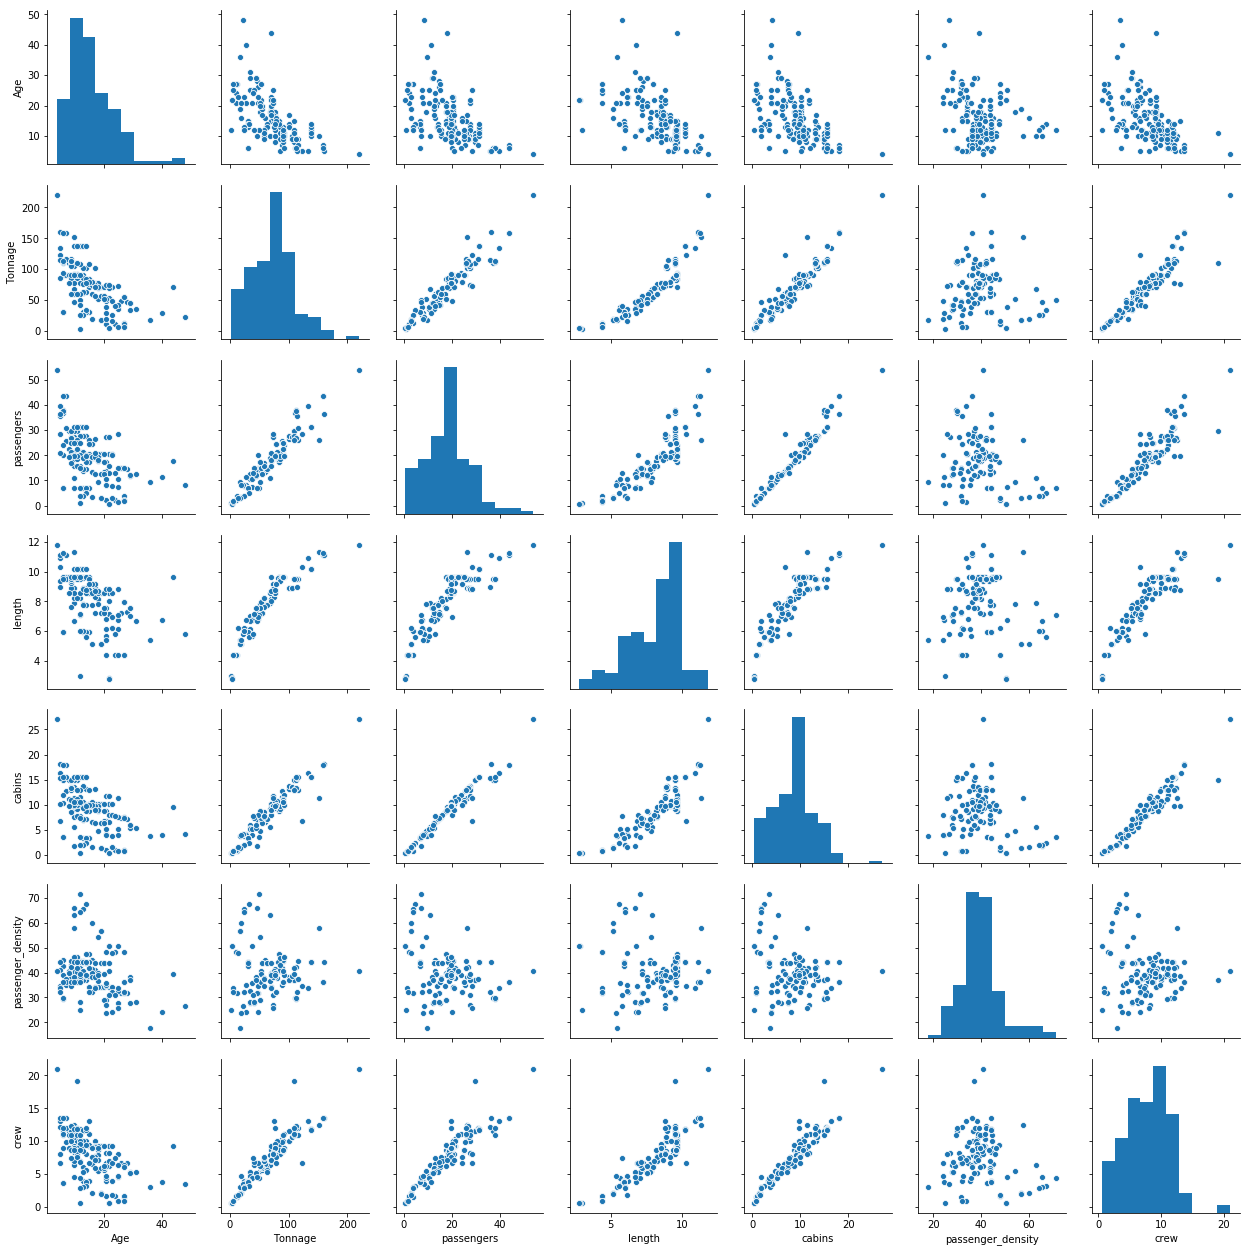

In [8]:
sns.pairplot(df.toPandas())

In [37]:
df.groupBy('Cruise_line').count().show()

+-----------------+-----+
|      Cruise_line|count|
+-----------------+-----+
|            Costa|   11|
|              P&O|    6|
|           Cunard|    3|
|Regent_Seven_Seas|    5|
|              MSC|    8|
|         Carnival|   22|
|          Crystal|    2|
|           Orient|    1|
|         Princess|   17|
|        Silversea|    4|
|         Seabourn|    3|
| Holland_American|   14|
|         Windstar|    3|
|           Disney|    2|
|        Norwegian|   13|
|          Oceania|    3|
|          Azamara|    2|
|        Celebrity|   10|
|             Star|    6|
|  Royal_Caribbean|   23|
+-----------------+-----+



In [9]:
# Check for missing Values
detect_missing(df)

,Ship_name,Cruise_line,Age,Tonnage,passengers,length,cabins,passenger_density,crew
,,,,,,,,,
Count of miss values:,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percentage of miss values:,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
# Check for Duplicates: 
detect_duplicates(df)

# df.dropDuplicates() # Drop duplicate values

Count of rows:  158
Count of distinct rows:  158


In [11]:
# select label + informative features:
df_selected = df.drop('Ship_name')

In [12]:
df_selected.printSchema()

root
 |-- Cruise_line: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tonnage: double (nullable = true)
 |-- passengers: double (nullable = true)
 |-- length: double (nullable = true)
 |-- cabins: double (nullable = true)
 |-- passenger_density: double (nullable = true)
 |-- crew: double (nullable = true)



In [13]:
# Preparing Data for Machine Learning: ___________________________

from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

# One-Hot-Encoding of Categorical features:
categoricalColumns = ['Cruise_line'] 
stages = []

for categoricalCol in categoricalColumns:
    
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + '_Index')
    encoder = OneHotEncoder(inputCol=stringIndexer.getOutputCol(), outputCol=categoricalCol + "_classVec")
    stages += [stringIndexer, encoder]


# Continuous features: 
numericCols = ['Age', 'Tonnage', 'passengers', 'length', 'cabins', 'passenger_density']

# Vector assembling:
assemblerInputs = [c + "_classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [14]:
# Pipeline: ___________________________________
from pyspark.ml import Pipeline

cols = df_selected.columns
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df_selected)
df_piped = pipelineModel.transform(df_selected)

selectedCols = ['features'] + cols
df_piped = df_piped.select(selectedCols)
df_piped = df_piped.withColumnRenamed('crew', 'label')

df_piped.printSchema()

root
 |-- features: vector (nullable = true)
 |-- Cruise_line: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tonnage: double (nullable = true)
 |-- passengers: double (nullable = true)
 |-- length: double (nullable = true)
 |-- cabins: double (nullable = true)
 |-- passenger_density: double (nullable = true)
 |-- label: double (nullable = true)



In [15]:
train, test = df_piped.randomSplit([0.75, 0.25], seed = 42)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 127
Test Dataset Count: 31


# 1) Linear Regression Model: 

In [18]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol = 'label', maxIter=50)

# creating the Evaluator: 
from  pyspark.ml import evaluation 

evaluator=evaluation.RegressionEvaluator(metricName='r2')

# creating the Grid of Parameters: 
from pyspark.ml import tuning

grid=tuning.ParamGridBuilder()
grid=grid.addGrid(lr.regParam, [0, 0.001, 0.01, 0.1, 1])
grid=grid.addGrid(lr.elasticNetParam, [0, 0.5, 1])
grid=grid.build()

# making the Validator:
cv=tuning.CrossValidator(estimator=lr,
                         estimatorParamMaps=grid,
                         evaluator=evaluator,
                         numFolds=3,
                         seed=42)

In [19]:
# fit the model:
models=cv.fit(train)
best_lr=models.bestModel

# Best hyper-parameters: 
java_model = best_lr._java_obj
print("Best hyper-parameters: ",  {param.name: java_model.getOrDefault(java_model.getParam(param.name)) 
                                                                                 for param in grid[0]})

Best hyper-parameters:  {'regParam': 0.1, 'elasticNetParam': 1.0}


In [20]:
# Prediction on test dataset:
test_predictions = best_lr.transform(test)
test_predictions.select('label', 'prediction').show(5)

+-----+------------------+
|label|        prediction|
+-----+------------------+
| 13.6|14.244421745440832|
| 13.6|14.168871071300956|
| 13.6|14.126356256037115|
|  6.6| 8.143889927132648|
|  7.2| 7.351070874747603|
+-----+------------------+
only showing top 5 rows



In [21]:
train_results = best_lr.evaluate(train)
test_results = best_lr.evaluate(test)

print('Training R^2 score: ', round(train_results.r2, 2))
print('Validation R^2 score: ', round(test_results.r2,2), '\n')

print('Training RMSE: ', round(train_results.rootMeanSquaredError, 2))
print('Validation RMSE: ', round(test_results.rootMeanSquaredError,2))

Training R^2 score:  0.94
Validation R^2 score:  0.93 

Training RMSE:  0.87
Validation RMSE:  0.97


# 2) Random Forest Model: 

In [22]:
from pyspark.ml.regression import RandomForestRegressor
rf = RandomForestRegressor(featuresCol = 'features', labelCol = 'label')

# creating the Evaluator: 
from  pyspark.ml import evaluation 
evaluator=evaluation.RegressionEvaluator(metricName='r2')

# creating the Grid of Parameters: 
from pyspark.ml import tuning

grid=tuning.ParamGridBuilder()
grid=grid.addGrid(rf.maxDepth, [5, 10])
grid=grid.addGrid(rf.numTrees, [100])
grid=grid.addGrid(rf.maxBins, [16, 32])

grid=grid.build()

# making the Validator:
cv=tuning.CrossValidator(estimator=rf,
                         estimatorParamMaps=grid,
                         evaluator=evaluator,
                         numFolds=3,
                         seed=42)

In [23]:
# fit the model:
models=cv.fit(train)
best_rf=models.bestModel

# Best hyper-parameters: 
java_model = best_rf._java_obj
print("Best hyper-parameters: ",  {param.name: java_model.getOrDefault(java_model.getParam(param.name)) 
                                                                                 for param in grid[0]})

Best hyper-parameters:  {'maxDepth': 10, 'numTrees': 100, 'maxBins': 32}


In [24]:
# Prediction on test dataset:
test_predictions = best_rf.transform(test)
test_predictions.select('label', 'prediction').show(5)

+-----+------------------+
|label|        prediction|
+-----+------------------+
| 13.6|14.120242976190474|
| 13.6| 14.62512047619048|
| 13.6|14.633120476190477|
|  6.6| 7.972128409090903|
|  7.2| 7.844585714285723|
+-----+------------------+
only showing top 5 rows



In [25]:
print('Training R^2 score: ', round(evaluation.RegressionEvaluator(metricName='r2').evaluate(best_rf.transform(train)) , 2))
print('Validation R^2 score: ', round(evaluation.RegressionEvaluator(metricName='r2').evaluate(best_rf.transform(train)) , 2), '\n')

print('Training RMSE: ', round(evaluation.RegressionEvaluator(metricName='rmse').evaluate(best_rf.transform(train)) , 2))
print('Validation RMSE: ', round(evaluation.RegressionEvaluator(metricName='rmse').evaluate(best_rf.transform(test)) , 2))

Training R^2 score:  0.98
Validation R^2 score:  0.98 

Training RMSE:  0.5
Validation RMSE:  0.99


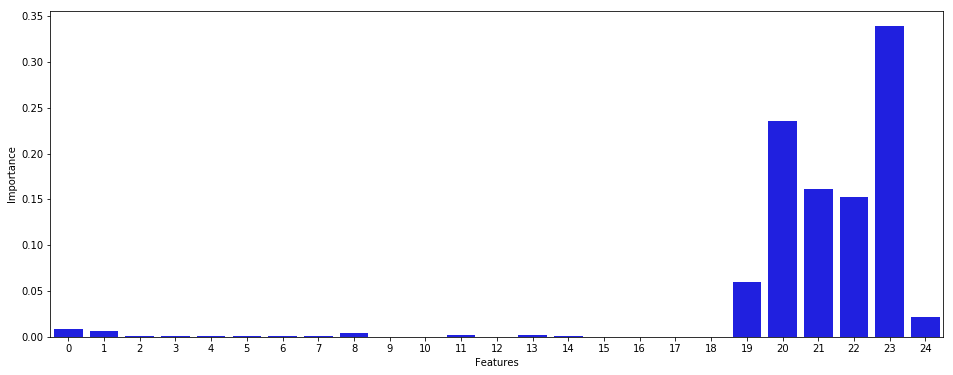

In [26]:
# Feature Importance: 
im=best_rf.featureImportances

# Plot:
c1=pd.DataFrame(im.toArray(),  columns=["Importance"])
c2=pd.DataFrame(np.arange(im.toArray().shape[0]), columns=["Features"])

fig, ax = plt.subplots(figsize=(16, 6)) 
sns.barplot(x="Features", y="Importance", data=pd.concat([c2,c1], axis=1), color="blue", ax=ax)

plt.show()

# 3) Gradient-Boosted Trees:

In [32]:
from pyspark.ml.regression import GBTRegressor
gb = GBTRegressor(featuresCol = 'features', labelCol = 'label')

# creating the Evaluator: 
from  pyspark.ml import evaluation 

evaluator=evaluation.RegressionEvaluator(metricName='r2')

# creating the Grid of Parameters: 
from pyspark.ml import tuning

grid=tuning.ParamGridBuilder()
grid=grid.addGrid(gb.maxDepth, [2, 4, 6])
grid=grid.addGrid(gb.maxIter, [20, 40])
grid=grid.addGrid(gb.maxBins, [8, 16])

grid=grid.build()

# making the Validator:
cv=tuning.CrossValidator(estimator=gb,
                         estimatorParamMaps=grid,
                         evaluator=evaluator,
                         numFolds=3,
                         seed=42)

In [33]:
# fit the model:
models=cv.fit(train)
best_gb=models.bestModel

# Best hyper-parameters: 
java_model = best_gb._java_obj
print("Best hyper-parameters: ",  {param.name: java_model.getOrDefault(java_model.getParam(param.name)) 
                                                                                 for param in grid[0]})

Best hyper-parameters:  {'maxDepth': 2, 'maxBins': 8, 'maxIter': 40}


In [34]:
# Prediction on test dataset:
test_predictions = best_gb.transform(test)
test_predictions.select('label', 'prediction').show(5)

+-----+------------------+
|label|        prediction|
+-----+------------------+
| 13.6|12.886573272005672|
| 13.6|14.020963263082646|
| 13.6|14.020963263082646|
|  6.6| 8.222004068178844|
|  7.2| 8.222004068178844|
+-----+------------------+
only showing top 5 rows



In [35]:
print('Training R^2 score: ', round(evaluation.RegressionEvaluator(metricName='r2').evaluate(best_gb.transform(train)) , 2))
print('Validation R^2 score: ', round(evaluation.RegressionEvaluator(metricName='r2').evaluate(best_gb.transform(train)) , 2), '\n')

print('Training RMSE: ', round(evaluation.RegressionEvaluator(metricName='rmse').evaluate(best_gb.transform(train)) , 2))
print('Validation RMSE: ', round(evaluation.RegressionEvaluator(metricName='rmse').evaluate(best_gb.transform(test)) , 2))

Training R^2 score:  0.92
Validation R^2 score:  0.92 

Training RMSE:  0.97
Validation RMSE:  1.39


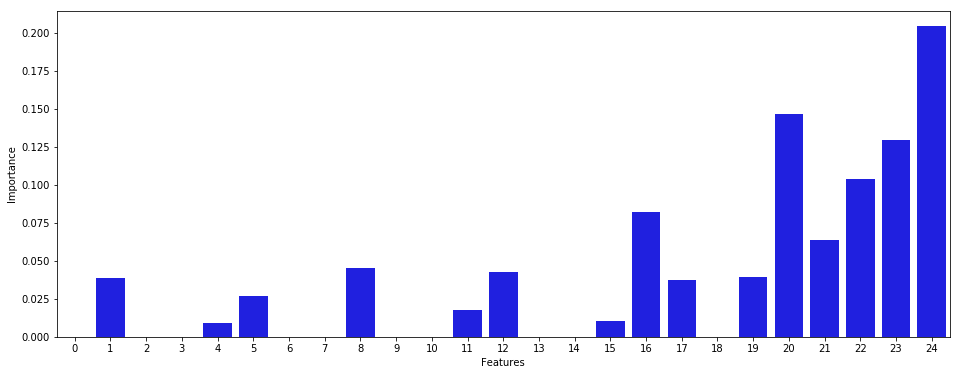

In [36]:
# Feature Importance: 
im=best_gb.featureImportances

# Plot:
c1=pd.DataFrame(im.toArray(),  columns=["Importance"])
c2=pd.DataFrame(np.arange(im.toArray().shape[0]), columns=["Features"])

fig, ax = plt.subplots(figsize=(16, 6)) 
sns.barplot(x="Features", y="Importance", data=pd.concat([c2,c1], axis=1), color="blue", ax=ax)

plt.show()